# Exploratory data analysis
In this notebook we explore the data generated in the [`data_wrangling.ipynb`](data_wrangling.ipynb) notebook. 

In [1]:
import os
import json

In [2]:
DATA_FOLDER = "/Users/giacomoorsi/MEGAsync Downloads/Trenitalia"

In [3]:
# Initial Spark
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.functions import explode
import pyspark.sql.types as T


spark = SparkSession.builder \
    .master("local[4]") \
    .appName("Trenitalia") \
    .getOrCreate()

# set driver memory to 4GB
spark.sparkContext._conf.setAll([('spark.driver.memory', '4g')])

# get sc 
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/17 15:54:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
import pandas as pd

sns.set_theme()


In [5]:
from pyspark.sql.functions import avg
from pyspark.sql.functions import stddev
from pyspark.sql.functions import col
from pyspark.sql.functions import count
from pyspark.sql.functions import percentile_approx

In [6]:
df = spark.read.parquet(os.path.join(DATA_FOLDER, "parquet", "all.parquet"))

In [8]:

# load the dataset of the stops
stops = spark.read.csv(os.path.join(DATA_FOLDER, "stops.csv"), header=True, inferSchema=True)

stops_column_renamer = {
    "name": "stop_name",
    "lat": "stop_lat",
    "lon": "stop_lon",
    "station_id": "stop_id", 
    "name_short": "stop_name_short",
    "id_region": "stop_id_region",
}

for k, v in stops_column_renamer.items():
    stops = stops.withColumnRenamed(k, v)

In [9]:
# number of days
print("Number of days: ", df.select("date").distinct().count())

# first date
print("First date: ", df.select("date").distinct().orderBy("date").first().asDict()["date"])

# last date
print("Last date: ", df.select("date").distinct().orderBy("date", ascending=False).first().asDict()["date"])

# number of trains
print("Number of trains: ", df.select("train_number").distinct().count())

# number of stops
print("Number of stops: ", df.select("stop_name").distinct().count())

# number of train classes
print("Number of train classes: ", df.select("train_class").distinct().count())


Number of days:  325


First date:  2022-02-15


Last date:  2023-01-06


Number of trains:  15034


Number of stops:  2430


Number of train classes:  12


In [10]:
# show list of train classes
train_classes = df.select("train_class").distinct().orderBy("train_class").collect()
print("Train classes: ", [t.asDict()["train_class"] for t in train_classes])

Train classes:  ['', 'DIR', 'EC', 'EN', 'EXP', 'IC', 'ICN', 'INV', 'IR', 'MET', 'NCL', 'REG']


In [11]:
# get list of cities
cities = df.select("stop_name").distinct().orderBy("stop_name").collect()
cities = [c.asDict()["stop_name"] for c in cities]


In [12]:
# store list as csv file
# import csv
# with open(os.path.join(DATA_FOLDER, "cities.csv"), "w") as f:
#     writer = csv.writer(f)
#     for c in cities:
#         writer.writerow([c])


## 1. Statistics on a specified train
We want to retrieve all the observations in order to plot a distribution plot. 

In [202]:
query_1 = {
    "train_class": "IC",
    "train_number": "655", 
    "stop_name" : "MILANO CENTRALE"
}

In [203]:
delays_of_train = df.filter(df.train_class == query_1["train_class"]) \
.filter(df.train_number == query_1["train_number"])

In [204]:
delays_of_train.show(5)

+-----------------------+-----------+--------+--------+------------+------------------+----+----------+--------+--------+--------------------+---------+----------+-------------------------+--------+-------------------+---------------------+----+---------+---------+---+-----+----+----------+-----------+-----------------+-------------------+------------------+--------------------+
|train_arrival_stop_name|train_class|train_cn|train_dl|train_number|train_arrival_time| oae| train_oaz|train_od|train_oo|train_departure_time|train_ope| train_opz|train_departure_stop_name|train_pr|train_arrival_delay|train_departure_delay| sea|train_sep|train_sub|day|month|year|      date|  stop_name|stop_arrival_time|stop_departure_time|stop_arrival_delay|stop_departure_delay|
+-----------------------+-----------+--------+--------+------------+------------------+----+----------+--------+--------+--------------------+---------+----------+-------------------------+--------+-------------------+------------------

In [205]:
# the stops of the train are 
delays_of_train.select("stop_name").distinct().collect()

[Row(stop_name='MILANO CENTRALE'),
 Row(stop_name='ALBENGA'),
 Row(stop_name='FINALE LIGURE MARINA'),
 Row(stop_name='IMPERIA'),
 Row(stop_name='MILANO ROGOREDO'),
 Row(stop_name='BORDIGHERA'),
 Row(stop_name='TAGGIA ARMA'),
 Row(stop_name='ALASSIO'),
 Row(stop_name='PAVIA'),
 Row(stop_name='GENOVA P.PRINCIPE'),
 Row(stop_name='VOGHERA'),
 Row(stop_name='SAVONA'),
 Row(stop_name='SANREMO'),
 Row(stop_name='VENTIMIGLIA'),
 Row(stop_name='DIANO'),
 Row(stop_name='ARQUATA SCRIVIA')]

In [206]:
delays_of_train_at_stop = delays_of_train.filter(delays_of_train.stop_name == query_1["stop_name"])
stop_arrival_delays = delays_of_train_at_stop.select("stop_arrival_delay").collect()

# collect as list of integers
stop_arrival_delays = [int(d.asDict()["stop_arrival_delay"]) for d in stop_arrival_delays if str(d.asDict()["stop_arrival_delay"]).isdigit()]

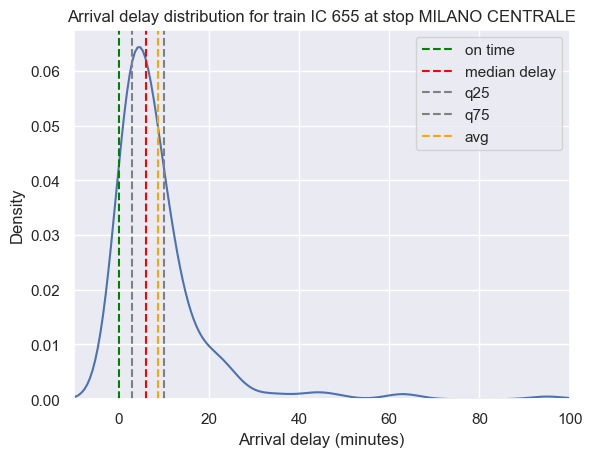

In [208]:
sns.kdeplot(stop_arrival_delays)
plt.xlabel("Arrival delay (minutes)")
plt.ylabel("Density")
plt.title("Arrival delay distribution for train {} {} at stop {}".format(query_1["train_class"], query_1["train_number"], query_1["stop_name"]))
# add punctuality line
plt.axvline(x=0, color="green", linestyle="--", label="on time")
# add median line
plt.axvline(x=np.median(stop_arrival_delays), color="red", linestyle="--", label="median delay")

# add q25 and q75 lines
plt.axvline(x=np.quantile(stop_arrival_delays, 0.25), color="grey", linestyle="--", label="q25")
plt.axvline(x=np.quantile(stop_arrival_delays, 0.75), color="grey", linestyle="--", label="q75")

# add avg
plt.axvline(x=np.mean(stop_arrival_delays), color="orange", linestyle="--", label="avg")


plt.xlim(-10, 100)
plt.legend()
plt.show()

In [ ]:
np.quantile(stop_arrival_delays, 0.95)

In [209]:
# compute the probability of being more than X minutes late 
MINUTES_LATE = 5
print("Probability of being more than {} minutes late: {}".format(MINUTES_LATE, len([d for d in stop_arrival_delays if d > MINUTES_LATE]) / len(stop_arrival_delays)))

Probability of being more than 5 minutes late: 0.5066666666666667


## 2. Statistics on a specified station
We want to retrieve all the observations in order to plot a distribution plot.

In [210]:
query = {
    "stop_name": "ACIREALE",
    "train_class": "IC"
}

In [211]:
delays_at_stop = df.filter(df.stop_name == query["stop_name"]).filter(df.train_class == query["train_class"])
delays_at_stop = delays_at_stop.select("stop_arrival_delay").collect()

In [212]:
delays_at_stop = [d.asDict()["stop_arrival_delay"] for d in delays_at_stop]

In [213]:
# keep only the numbers, skip strings
delays_at_stop = [int(d) for d in delays_at_stop if str(d).isdigit()]

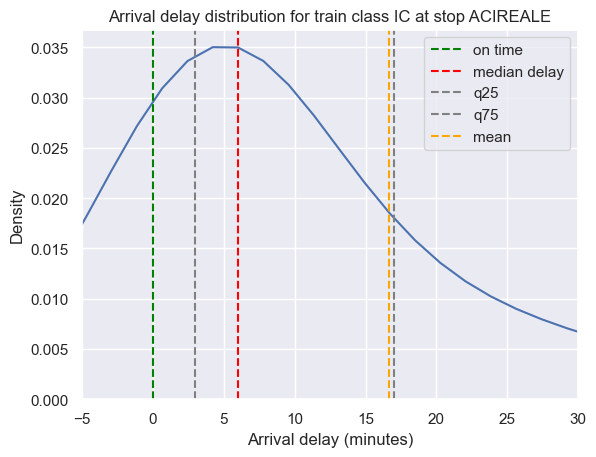

In [214]:
sns.kdeplot(delays_at_stop)
plt.xlabel("Arrival delay (minutes)")
plt.ylabel("Density")
plt.title("Arrival delay distribution for train class {} at stop {}".format(query["train_class"], query["stop_name"]))
plt.xlim(-5, 30)

# vertical line on 0 with label "on time"
plt.axvline(x=0, color="green", label="on time", linestyle="--")

# vertical line with median delay
plt.axvline(x=np.median(delays_at_stop), color="red", label="median delay", linestyle="--")

# vertical line with first quantile
plt.axvline(x=np.quantile(delays_at_stop, 0.25), color="grey", label="q25", linestyle="--")

# vertical line with third quantile
plt.axvline(x=np.quantile(delays_at_stop, 0.75), color="grey", label="q75", linestyle="--")

# vertical line with average delay
plt.axvline(x=np.mean(delays_at_stop), color="orange", label="mean", linestyle="--")

plt.legend()
plt.show()

## 3. Statistics on all stations. Ranking of the worst stations
We want to compute statistics on all the stations for a given train class. In particular, we want the 25th, 50th and 75th percentile, the mean and the standard deviation.

In [215]:
query_3 = {
    "train_class": "IC"
}

In [216]:
delays_3 = df.filter(df.train_class == query_3["train_class"])

In [217]:
# group by stopname and compute statistics (quantiles)
delays_3 = delays_3.groupBy("stop_name").agg(
    avg("stop_arrival_delay").alias("avg_arrival_delay"),
    stddev("stop_arrival_delay").alias("stddev_arrival_delay"),
    count("stop_arrival_delay").alias("count_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.25).alias("q1_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.5).alias("q2_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.75).alias("q3_arrival_delay")
)


In [218]:
delays_3.show(5)

+--------------------+------------------+--------------------+-------------------+----------------+----------------+----------------+
|           stop_name| avg_arrival_delay|stddev_arrival_delay|count_arrival_delay|q1_arrival_delay|q2_arrival_delay|q3_arrival_delay|
+--------------------+------------------+--------------------+-------------------+----------------+----------------+----------------+
|            ACIREALE|12.633278145695364|   28.17404397874824|               1338|             1.0|             4.0|            13.0|
|        AGNONE DI S.|  9.21951219512195|  13.797666822912403|                 41|             1.0|             5.0|            16.0|
|AGROPOLI CASTELLA...|14.144300144300145|  28.325540445993404|               2088|             0.0|             5.0|            16.0|
|             ALASSIO| 9.797219950940312|  13.279493872258085|               2454|             3.0|             7.0|            12.0|
|ALBA ADRIATICA NE...|17.423076923076923|  13.807745875190713|

In [219]:
# order by the highest average delay and keep only those with at least 33% of the samples with a delay
max_observations = delays_3.agg({"count_arrival_delay": "max"}).collect()[0][0]
delays_3 = delays_3.filter(delays_3.count_arrival_delay > 50).orderBy("avg_arrival_delay", ascending=False)
delays_3.show(100)
print("The table shows the worse stops for train class {}, based on average arrival delay".format(query_3["train_class"]))

+--------------------+------------------+--------------------+-------------------+----------------+----------------+----------------+
|           stop_name| avg_arrival_delay|stddev_arrival_delay|count_arrival_delay|q1_arrival_delay|q2_arrival_delay|q3_arrival_delay|
+--------------------+------------------+--------------------+-------------------+----------------+----------------+----------------+
|VILLA S.GIOVANNI ...|27.666666666666668|   44.31487026793975|                372|             0.0|            10.0|            35.0|
|   MESSINA MARITTIMA| 25.63172804532578|  40.585282145562594|                372|             0.0|            10.0|            30.0|
|            SIRACUSA| 22.35477582846004|   43.35962963436989|               1340|             1.0|             7.0|            29.0|
|               PALMI|22.083333333333332|   41.82387708806862|                120|             3.0|             7.0|            17.0|
|         VIBO MARINA|  21.8476821192053|  31.605384196750364|

Observation: we need to tune a parameter that allows us to exclude the stations with few observations.

In [ ]:
delays_3.count()

## 4. Statistics on all trains. Ranking of the worst trains
We want to compute statistics on all the trains for all their stops. In particular, we want the 25th, 50th and 75th percentile, the mean and the standard deviation.

In [ ]:
query_4 = {
    "train_class": "REG"
}

In [ ]:
delays = df.filter(df.train_class == query_4["train_class"])

In [ ]:
df.show(1)

In [ ]:
# group by train_number and compute statistics (quantiles)
delays = delays.groupBy(["train_number", "train_departure_stop_name", "train_arrival_stop_name"]).agg(
    avg("stop_arrival_delay").alias("avg_arrival_delay"),
    stddev("stop_arrival_delay").alias("stddev_arrival_delay"),
    count("stop_arrival_delay").alias("count_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.25).alias("q1_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.5).alias("q2_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.75).alias("q3_arrival_delay")
)


In [ ]:
# order by the highest average delay and keep only those with at least 33% of the samples with a delay
max_observations = delays.agg({"count_arrival_delay": "max"}).collect()[0][0]
delays = delays.filter(delays.count_arrival_delay > max_observations / 3).orderBy("avg_arrival_delay", ascending=False)
delays.show(100)
print("The table shows the worse trains {}, based on average arrival delay".format(query_4["train_class"]))

### 5. Delays of each stop, let's try to visualize on map


In [13]:
query_5 = {
    "train_class": "REG"
}
delays_5 = df.filter(df.train_class == query_5["train_class"])
# group by stopname and compute statistics (quantiles)
delays_5 = delays_5.groupBy("stop_name").agg(
    avg("stop_arrival_delay").alias("avg_arrival_delay"),
    stddev("stop_arrival_delay").alias("stddev_arrival_delay"),
    count("stop_arrival_delay").alias("count_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.25).alias("q1_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.5).alias("q2_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.75).alias("q3_arrival_delay")
)


In [14]:
# merge the two datasets
delays_5 = delays_5.join(stops, on="stop_name", how="left")

In [15]:
# keep only the 10 worse stops
max_observations = delays_5.agg({"count_arrival_delay": "max"}).collect()[0][0]
delays_5 = delays_5.filter(delays_5.count_arrival_delay > 50).orderBy("avg_arrival_delay", ascending=False)

# convert to pandas
delays_5_pd = delays_5.toPandas()

In [16]:
# drop rows with NaN values
delays_5_pd = delays_5_pd.dropna()

In [17]:
delays_5_pd.head()

,stop_name,avg_arrival_delay,stddev_arrival_delay,count_arrival_delay,q1_arrival_delay,q2_arrival_delay,q3_arrival_delay,stop_id,stop_name_short,stop_lat,stop_lon,stop_id_region
0,PONTETTO,44.125000,55.794105,4605,5.0,10.0,46.0,S04710,Pontetto,44.377309,9.076960,2.0
1,BRENNA-ALZATE,41.250000,32.024730,5359,7.0,25.0,53.0,S01452,Brenna-Alzate,45.754044,9.183312,1.0
2,ANZANO DEL PARCO,28.333333,22.188586,5359,8.0,25.0,52.0,S01453,Anzano del Parco,45.764965,9.202676,1.0
4,GENOVA COSTA DI SESTRI PONENTE,22.333333,24.846194,5899,7.0,9.0,51.0,S04110,GE Costa Sestri,44.433535,8.845530,2.0
5,MALTIGNANO DEL TRONTO,22.333333,9.609024,3275,12.0,24.0,31.0,S07555,Maltignano T.,42.844918,13.664738,11.0


In [18]:
# keep only positive values
delays_5_pd = delays_5_pd[delays_5_pd.avg_arrival_delay > 0]

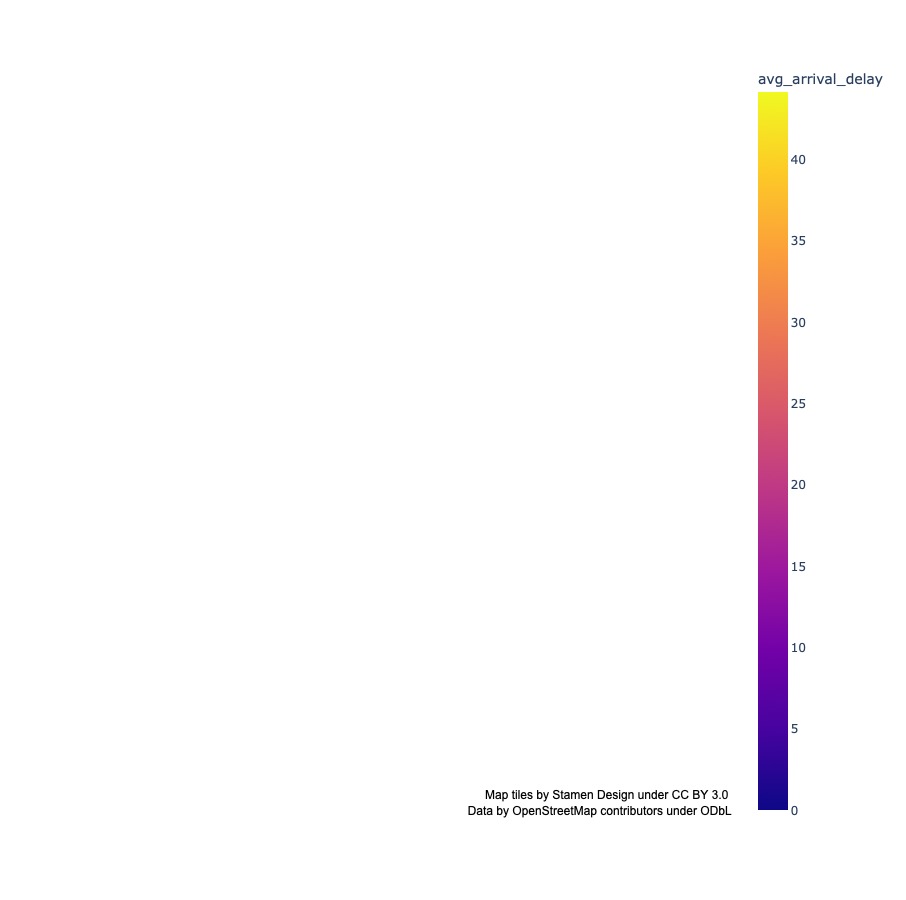

In [19]:
# show the map with plotly express
import plotly.express as px
fig = px.density_mapbox(delays_5_pd, lat='stop_lat', lon='stop_lon', z='avg_arrival_delay', radius=25,  zoom=4, mapbox_style="stamen-terrain")
# set higher height
fig.update_layout(height=900)
fig.update_layout(width=1200)

fig.show()

### 6. Density of trains over a map
Here we show the density of trains over a map, for each stop we consider the number of observations registered there. 

In [20]:
counts = df.groupBy("stop_name").agg(count("stop_arrival_delay").alias("number_of_observations"))
counts = counts.join(stops, on="stop_name", how="left")

In [21]:
counts_pd = counts.toPandas()

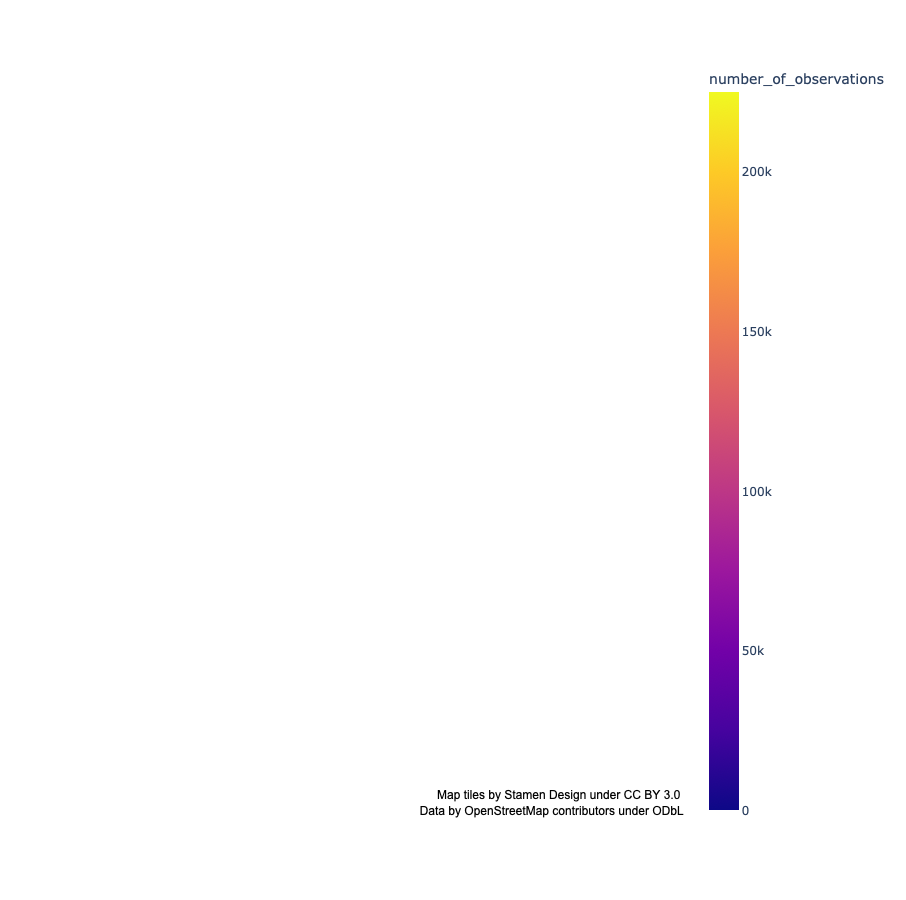

In [22]:
# show the map with plotly express
import plotly.express as px
fig = px.density_mapbox(counts_pd, lat='stop_lat', lon='stop_lon', z='number_of_observations', radius=25,  zoom=4, mapbox_style="stamen-terrain")
# set higher height
fig.update_layout(height=900)
fig.update_layout(width=1200)

fig.show()

## 7. Show a train over a map, with information on the punctuality at each stop 

In [23]:
query_7 = {
    "train_class": "IC", 
    "train_number": "655"
}

In [24]:
train_data = df.filter(col("train_class") == query_7["train_class"]).filter(col("train_number") == query_7["train_number"])

In [25]:
train_data.show(10)

23/03/17 16:08:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+-----------------------+-----------+--------+--------+------------+------------------+----+----------+--------+--------+--------------------+---------+----------+-------------------------+--------+-------------------+---------------------+----+---------+---------+---+-----+----+----------+--------------------+-----------------+-------------------+------------------+--------------------+
|train_arrival_stop_name|train_class|train_cn|train_dl|train_number|train_arrival_time| oae| train_oaz|train_od|train_oo|train_departure_time|train_ope| train_opz|train_departure_stop_name|train_pr|train_arrival_delay|train_departure_delay| sea|train_sep|train_sub|day|month|year|      date|           stop_name|stop_arrival_time|stop_departure_time|stop_arrival_delay|stop_departure_delay|
+-----------------------+-----------+-

In [26]:
# convert stop_arrival_time to HH:mm
train_data2 = train_data.withColumnRenamed("stop_arrival_time", "stop_arrival_time_unix").withColumnRenamed("stop_departure_time", "stop_departure_time_unix")

In [27]:
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import to_timestamp

In [28]:
train_data3 = train_data2.withColumn("stop_departure_time", from_unixtime(col("stop_departure_time_unix"), "HH:mm:ss")).withColumn("stop_arrival_time", from_unixtime(col("stop_arrival_time_unix"), "HH:mm:ss"))

In [29]:
train_data3.select(["stop_departure_time", "stop_departure_time_unix"]).show(10)

+-------------------+------------------------+
|stop_departure_time|stop_departure_time_unix|
+-------------------+------------------------+
|           04:51:00|              1650336660|
|           04:58:00|              1650337080|
|           05:08:00|              1650337680|
|           05:14:00|              1650338040|
|           05:24:00|              1650338640|
|           05:37:00|              1650339420|
|           05:45:00|              1650339900|
|           06:00:00|              1650340800|
|           06:17:00|              1650341820|
|           07:19:00|              1650345540|
+-------------------+------------------------+
only showing top 10 rows



In [30]:
# obtain statistics at each stop 
train_data4 = train_data3.groupBy(["stop_name", "stop_departure_time"]).agg(
    avg("stop_arrival_delay").alias("avg_arrival_delay"),
    stddev("stop_arrival_delay").alias("stddev_arrival_delay"),
    count("stop_arrival_delay").alias("count_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.25).alias("q1_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.5).alias("q2_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.75).alias("q3_arrival_delay")
)

In [31]:
# add data of the stops
train_data4 = train_data4.join(stops, on="stop_name", how="left")

In [32]:
train_data_df = train_data4.toPandas()
train_data_df.head(15)

,stop_name,stop_departure_time,avg_arrival_delay,stddev_arrival_delay,count_arrival_delay,q1_arrival_delay,q2_arrival_delay,q3_arrival_delay,stop_id,stop_name_short,stop_lat,stop_lon,stop_id_region
0,ALASSIO,05:37:00,6.637838,6.874154,185,4.0,5.0,8.0,S04515,Alassio,44.007889,8.171120,2.0
1,MILANO ROGOREDO,08:50:00,6.380952,7.324453,21,2.0,4.0,10.0,S01820,Milano Rogoredo,45.433866,9.239100,1.0
2,FINALE LIGURE MARINA,06:00:00,6.511538,8.562053,260,3.0,5.0,8.0,S04522,Finale Ligure M.,44.169116,8.340330,2.0
3,SAVONA,06:17:00,3.111538,8.718632,260,-1.0,2.0,4.0,S04801,Savona,44.306892,8.470259,2.0
4,IMPERIA,05:24:00,5.161290,6.566566,186,3.0,4.0,6.0,S04523,Imperia,43.880510,8.019182,2.0
5,GENOVA P.PRINCIPE,07:19:00,1.781250,9.533378,256,-1.0,1.0,3.0,S04700,Genova P.Princ.,44.417784,8.920700,2.0
6,PAVIA,08:25:00,10.585470,10.527053,236,5.0,8.0,12.0,S01860,Pavia,45.188843,9.144674,1.0
7,SANREMO,05:08:00,8.272727,15.228988,186,2.0,4.0,8.0,S04505,Sanremo,43.821269,7.766693,2.0
8,BORDIGHERA,04:58:00,4.239130,6.063182,186,3.0,3.0,4.0,S04503,Bordighera,43.778313,7.663504,2.0
9,ALBENGA,05:45:00,7.343629,8.011237,260,4.0,6.0,9.0,S04516,Albenga,44.047220,8.221663,2.0


In [33]:
train_data_df[train_data_df["stop_name"] == "GENOVA P.PRINCIPE"].head(100)

,stop_name,stop_departure_time,avg_arrival_delay,stddev_arrival_delay,count_arrival_delay,q1_arrival_delay,q2_arrival_delay,q3_arrival_delay,stop_id,stop_name_short,stop_lat,stop_lon,stop_id_region
5,GENOVA P.PRINCIPE,07:19:00,1.781250,9.533378,256,-1.0,1.0,3.0,S04700,Genova P.Princ.,44.417784,8.9207,2.0
22,GENOVA P.PRINCIPE,01:00:00,0.000000,NaN,1,0.0,0.0,0.0,S04700,Genova P.Princ.,44.417784,8.9207,2.0
26,GENOVA P.PRINCIPE,07:09:00,-1.000000,3.000000,3,-4.0,-1.0,2.0,S04700,Genova P.Princ.,44.417784,8.9207,2.0
33,GENOVA P.PRINCIPE,15:16:00,13.666667,8.504901,3,5.0,14.0,22.0,S04700,Genova P.Princ.,44.417784,8.9207,2.0
43,GENOVA P.PRINCIPE,15:20:00,3.787234,6.899704,47,-1.0,2.0,7.0,S04700,Genova P.Princ.,44.417784,8.9207,2.0


In [34]:
from pyspark.sql.functions import countDistinct

In [35]:
### We notice that for this train number there's clearly different schedules. Let's dig more...
### by grouping by stop_name and stop_departure_time we can see the different schedules. We extract some information like the min and max date of the schedule
train_data5 = train_data3.groupBy(["stop_name", "stop_departure_time"]).agg(
    avg("stop_arrival_delay").alias("avg_arrival_delay"),
    stddev("stop_arrival_delay").alias("stddev_arrival_delay"),
    countDistinct("date").alias("count_distinct_dates"),
    percentile_approx("stop_arrival_delay", 0.25).alias("q1_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.5).alias("q2_arrival_delay"),
    percentile_approx("stop_arrival_delay", 0.75).alias("q3_arrival_delay"), 
    pyspark.sql.functions.min("date").alias("schedule_starting_date"),
    pyspark.sql.functions.max("date").alias("schedule_ending_date")
)

In [36]:
train_data5_df = train_data5.toPandas()
train_data5_df[train_data5_df["stop_name"] == "GENOVA P.PRINCIPE"].sort_values("schedule_starting_date").head(100)

,stop_name,stop_departure_time,avg_arrival_delay,stddev_arrival_delay,count_distinct_dates,q1_arrival_delay,q2_arrival_delay,q3_arrival_delay,schedule_starting_date,schedule_ending_date
14,GENOVA P.PRINCIPE,07:19:00,1.781250,9.533378,256,-1.0,1.0,3.0,2022-02-15,2023-01-05
37,GENOVA P.PRINCIPE,15:20:00,3.787234,6.899704,47,-1.0,2.0,7.0,2022-02-20,2023-01-06
34,GENOVA P.PRINCIPE,07:09:00,-1.000000,3.000000,3,-4.0,-1.0,2.0,2022-05-21,2022-12-03
13,GENOVA P.PRINCIPE,15:16:00,13.666667,8.504901,3,5.0,14.0,22.0,2022-05-22,2022-12-04
24,GENOVA P.PRINCIPE,01:00:00,0.000000,NaN,1,0.0,0.0,0.0,2022-12-07,2022-12-07


This clearly shows that the train runs on different schedules at the same time, it probably means that on some days of a week it has a schedule, and on others it has a different one.  
It seems there are two different periods with different times. 
One goes from 15/02/2022 -> now; and the other goes from 02/05/2022 -> 04/12/2022, which makes sense ! 

In [37]:
### assume we add additional information to the query
query_7["day_of_week"] = "1" # sunday
query_7["schedule_starting_date"] = "2022-02-15"

In [38]:
train_data6 = train_data5.filter("date" >= lit(query_7["schedule_starting_date"])) \
#     .groupBy(["stop_name", "stop_departure_time"]).agg(
#     avg("stop_arrival_delay").alias("avg_arrival_delay"),
#     stddev("stop_arrival_delay").alias("stddev_arrival_delay"),
#     count("stop_arrival_delay").alias("count_arrival_delay"),
#     percentile_approx("stop_arrival_delay", 0.25).alias("q1_arrival_delay"),
#     percentile_approx("stop_arrival_delay", 0.5).alias("q2_arrival_delay"),
#     percentile_approx("stop_arrival_delay", 0.75).alias("q3_arrival_delay"), 
#     pyspark.sql.functions.min("date").alias("schedule_starting_date"),
#     pyspark.sql.functions.max("date").alias("schedule_ending_date")
# )

In [39]:
train_data6_df = train_data6.toPandas()
train_data6_df[train_data6_df["stop_name"] == "GENOVA P.PRINCIPE"].sort_values("schedule_starting_date").head(100)

,stop_name,stop_departure_time,avg_arrival_delay,stddev_arrival_delay,count_distinct_dates,q1_arrival_delay,q2_arrival_delay,q3_arrival_delay,schedule_starting_date,schedule_ending_date
14,GENOVA P.PRINCIPE,07:19:00,1.781250,9.533378,256,-1.0,1.0,3.0,2022-02-15,2023-01-05
37,GENOVA P.PRINCIPE,15:20:00,3.787234,6.899704,47,-1.0,2.0,7.0,2022-02-20,2023-01-06
34,GENOVA P.PRINCIPE,07:09:00,-1.000000,3.000000,3,-4.0,-1.0,2.0,2022-05-21,2022-12-03
13,GENOVA P.PRINCIPE,15:16:00,13.666667,8.504901,3,5.0,14.0,22.0,2022-05-22,2022-12-04
24,GENOVA P.PRINCIPE,01:00:00,0.000000,NaN,1,0.0,0.0,0.0,2022-12-07,2022-12-07


In [40]:
# TODO: we need an algorithm that is able to identify different schedules for the same train number
# and then provide a way to filter a particular schedule


In [41]:
fig = px.scatter_mapbox(
    train_data_df, 
    lat = "stop_lat", 
    lon = "stop_lon",
    hover_name = "stop_name_short",
    height = 400, 
    width = 700,
    zoom = 7
)

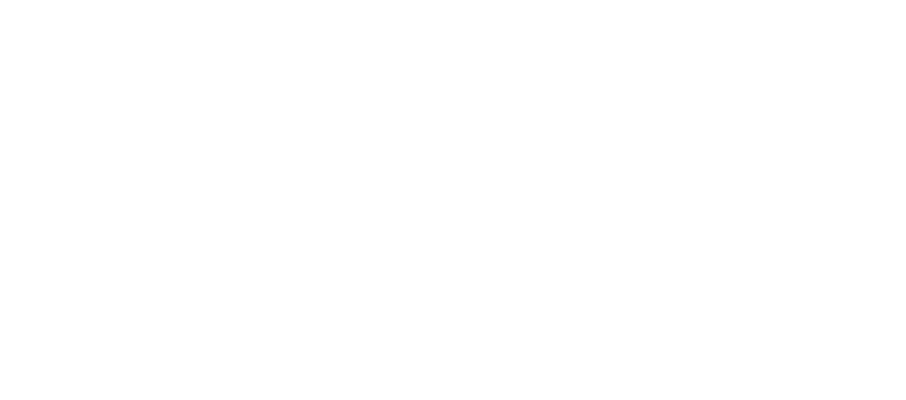

In [42]:
#fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(mapbox_style = "https://demotiles.maplibre.org/style.json")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(mapbox_bounds={"west": -180, "east": -50, "south": 20, "north": 90})
fig.show()

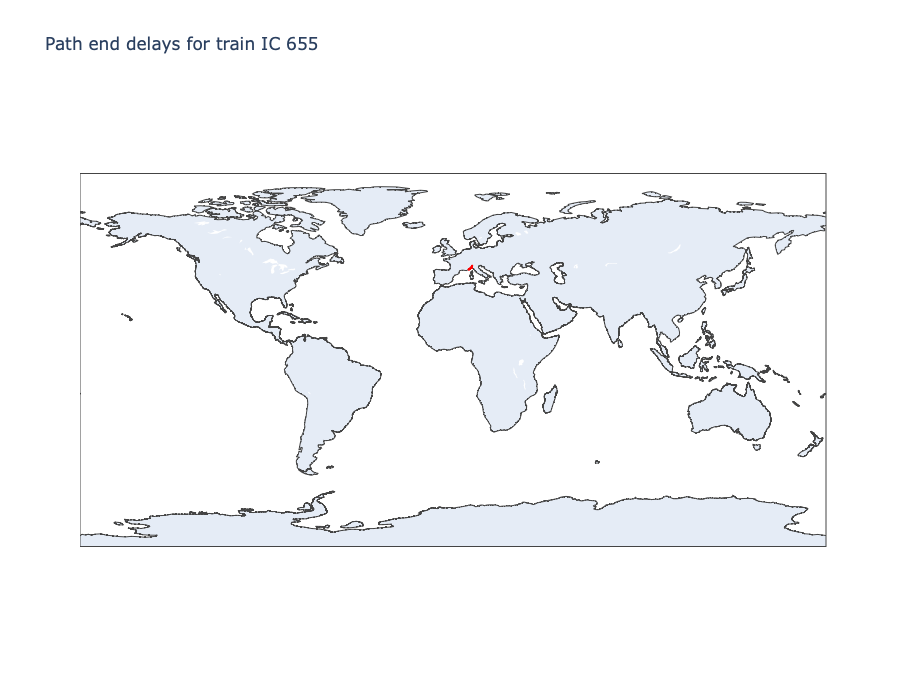

23/03/17 18:03:37 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 224406 ms exceeds timeout 120000 ms
23/03/17 18:03:37 WARN SparkContext: Killing executors is not supported by current scheduler.


In [43]:
import plotly.graph_objects as go
fig = go.Figure(
)

TOKEN = "pk.eyJ1IjoiZ2lhY29tb29yc2kiLCJhIjoiY2pubTM0Nml6MW02MDNwcWY0ajc3ZHE3diJ9.fz0p1ZmseERTYVzXJPqS0Q"

fig.add_trace(go.Scattergeo(
    lon = train_data_df['stop_lon'],
    lat = train_data_df['stop_lat'],
    hoverinfo = 'text',
    text = "stop_name_short",
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.update_mapboxes(
    accesstoken = TOKEN,
    style="https://demotiles.maplibre.org/style.json"
)

fig.update_layout(
    title_text = 'Path end delays for train {} {}'.format(query_7["train_class"], query_7["train_number"]),
    showlegend = False,
    height=700,
)

### GTFS
Let's try to make a simple example in which we generate a GTFS file from a day of the dataset.

In [126]:
query_day = {
    "date": "2022-02-15",
}
train_data_day = train_data3 \
    .join(stops, on="stop_name", how="left") \
    .filter(col("date") == query_day["date"])
train_data_day_df = train_data_day.toPandas()
train_data_day_df

,stop_name,train_arrival_stop_name,train_class,train_cn,train_dl,train_number,train_arrival_time,oae,train_oaz,train_od,...,stop_departure_time_unix,stop_arrival_delay,stop_departure_delay,stop_departure_time,stop_arrival_time,stop_id,stop_name_short,stop_lat,stop_lon,stop_id_region
0,VENTIMIGLIA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644897060,N,1,04:51:00,01:00:00,S04501,Ventimiglia,43.792561,7.610224,2
1,BORDIGHERA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644897480,5,5,04:58:00,04:56:00,S04503,Bordighera,43.778313,7.663504,2
2,SANREMO,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644898080,3,4,05:08:00,05:06:00,S04505,Sanremo,43.821269,7.766693,2
3,TAGGIA ARMA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644898440,3,4,05:14:00,05:12:00,S04506,Taggia Arma,43.840764,7.835604,2
4,IMPERIA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644899040,3,3,05:24:00,05:22:00,S04523,Imperia,43.880510,8.019182,2
5,ALASSIO,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644899820,4,5,05:37:00,05:35:00,S04515,Alassio,44.007889,8.171120,2
6,ALBENGA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644900300,3,4,05:45:00,05:43:00,S04516,Albenga,44.047220,8.221663,2
7,FINALE LIGURE MARINA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644901200,2,3,06:00:00,05:58:00,S04522,Finale Ligure M.,44.169116,8.340330,2
8,SAVONA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644902220,-2,2,06:17:00,06:14:00,S04801,Savona,44.306892,8.470259,2
9,GENOVA P.PRINCIPE,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644905940,-1,1,07:19:00,06:55:00,S04700,Genova P.Princ.,44.417784,8.920700,2


In [68]:
# we now have all the stops for a particular day, we can create our GTFS file

In [74]:
!mkdir gtfs

In [75]:
# 1. Create the agency.txt file
agency = {
    "agency_id": "1",
    "agency_name": "Trenitalia",
    "agency_url": "https://www.trenitalia.com",
    "agency_timezone": "Europe/Rome",
    "agency_lang": "it",
    "agency_phone": ""
}
agency = pd.DataFrame(agency, index=[0])
agency.to_csv("gtfs/agency.txt", index=False)

In [76]:
# 2. create routes.txt
# docs: https://gtfs.org/schedule/reference/#routestxt
routes = [{
    "agency_id": "1",
    "route_id": "1",
    "route_short_name": query_7["train_class"] + " " + query_7["train_number"],
    "route_long_name": query_7["train_class"] + " " + query_7["train_number"],
    "route_type": "2", # 2 is train
    "route_color": "",
    "route_text_color": "",
}]
routes = pd.DataFrame(routes)
routes.to_csv("gtfs/routes.txt", index=False)

In [82]:
train_data_df.head()

,stop_name,stop_departure_time,avg_arrival_delay,stddev_arrival_delay,count_arrival_delay,q1_arrival_delay,q2_arrival_delay,q3_arrival_delay,stop_id,stop_name_short,stop_lat,stop_lon,stop_id_region
0,BORDIGHERA,04:58,4.239130,6.063182,186,3.0,3.0,4.0,S04503,Bordighera,43.778313,7.663504,2.0
1,MILANO ROGOREDO,08:48,8.414530,10.805894,236,3.0,6.0,11.0,S01820,Milano Rogoredo,45.433866,9.239100,1.0
2,TAGGIA ARMA,05:14,4.681081,6.185618,186,2.0,4.0,5.0,S04506,Taggia Arma,43.840764,7.835604,2.0
3,PAVIA,08:26,8.952381,7.996726,21,3.0,6.0,10.0,S01860,Pavia,45.188843,9.144674,1.0
4,ALASSIO,05:37,6.637838,6.874154,185,4.0,5.0,8.0,S04515,Alassio,44.007889,8.171120,2.0


In [83]:
train_data_day_df

,stop_name,train_arrival_stop_name,train_class,train_cn,train_dl,train_number,train_arrival_time,oae,train_oaz,train_od,...,stop_arrival_time_unix,stop_departure_time_unix,stop_arrival_delay,stop_departure_delay,stop_departure_time,stop_id,stop_name_short,stop_lat,stop_lon,stop_id_region
0,VENTIMIGLIA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,0,1644897060,N,1,04:51,S04501,Ventimiglia,43.792561,7.610224,2
1,BORDIGHERA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644897360,1644897480,5,5,04:58,S04503,Bordighera,43.778313,7.663504,2
2,SANREMO,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644897960,1644898080,3,4,05:08,S04505,Sanremo,43.821269,7.766693,2
3,TAGGIA ARMA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644898320,1644898440,3,4,05:14,S04506,Taggia Arma,43.840764,7.835604,2
4,IMPERIA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644898920,1644899040,3,3,05:24,S04523,Imperia,43.880510,8.019182,2
5,ALASSIO,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644899700,1644899820,4,5,05:37,S04515,Alassio,44.007889,8.171120,2
6,ALBENGA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644900180,1644900300,3,4,05:45,S04516,Albenga,44.047220,8.221663,2
7,FINALE LIGURE MARINA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644901080,1644901200,2,3,06:00,S04522,Finale Ligure M.,44.169116,8.340330,2
8,SAVONA,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644902040,1644902220,-2,2,06:17,S04801,Savona,44.306892,8.470259,2
9,GENOVA P.PRINCIPE,MILANO CENTRALE,IC,None,None,655,1644912000,None,1644912000,None,...,1644904500,1644905940,-1,1,07:19,S04700,Genova P.Princ.,44.417784,8.920700,2


In [141]:
# 3. create stops.txt
# docs: https://gtfs.org/schedule/reference/#stopstxt
stops_gtfs = train_data_day_df[["stop_id", "stop_name", "stop_lat", "stop_lon"]].drop_duplicates()
stops_gtfs.to_csv("gtfs/stops.txt", index=False)

In [130]:
# 4. Tough one, create calendar.txt and trips.txt
# calendar describes the span of a service
# trips describes the service for a particular route

# 4a: create calendar.txt
# docs: https://gtfs.org/schedule/reference/#calendartxt
calendar = {
    # we just create a service that runs every day for the whole year
    "service_id": "1",
    "monday": "1",
    "tuesday": "1",
    "wednesday": "1",
    "thursday": "1",
    "friday": "1",
    "saturday": "1",
    "sunday": "1",
    "start_date": "19000101",
    "end_date": "21000101",
}
calendar = pd.DataFrame(calendar, index=[0])
calendar.to_csv("gtfs/calendar.txt", index=False)


In [89]:
# 4b: create trips.txt
# docs: https://gtfs.org/schedule/reference/#tripstxt
trips = {
    "route_id": "1",
    "service_id": "1",
    "trip_id": "1",
    "trip_headsign": query_7["train_class"] + " " + query_7["train_number"],
    "trip_short_name": query_7["train_class"] + " " + query_7["train_number"],
    "direction_id": "",
    "block_id": "",
    "shape_id": "",
    "wheelchair_accessible": "",
    "bikes_allowed": "",
}
trips = pd.DataFrame(trips, index=[0])
trips.to_csv("gtfs/trips.txt", index=False)

In [135]:
# 5. create stop_times.txt
# docs: https://gtfs.org/schedule/reference/#stop_timestxt
# convert stop_departure_time to HH:MM:SS using pyspark function

stop_times: pd.DataFrame = train_data_day_df[["stop_id", "stop_departure_time", "stop_arrival_time"]] \
    .rename(columns={"stop_id": "stop_id", "stop_departure_time": "departure_time", "stop_arrival_time": "arrival_time"})
                                                                                                            
# add column with stop_sequence
stop_times["stop_sequence"] = stop_times.index + 1
# add column with trip_id
stop_times["trip_id"] = "1"
# put departure time of the last stop equal to the arrival time
stop_times.loc[stop_times.index[-1], "departure_time"] = stop_times.loc[stop_times.index[-1], "arrival_time"]
# store it
stop_times.to_csv("gtfs/stop_times.txt", index=False)


In [136]:
stop_times

,stop_id,departure_time,arrival_time,stop_sequence,trip_id
0,S04501,04:51:00,01:00:00,1,1
1,S04503,04:58:00,04:56:00,2,1
2,S04505,05:08:00,05:06:00,3,1
3,S04506,05:14:00,05:12:00,4,1
4,S04523,05:24:00,05:22:00,5,1
5,S04515,05:37:00,05:35:00,6,1
6,S04516,05:45:00,05:43:00,7,1
7,S04522,06:00:00,05:58:00,8,1
8,S04801,06:17:00,06:14:00,9,1
9,S04700,07:19:00,06:55:00,10,1


In [138]:
import plotly.graph_objects as go

In [142]:
stops_gtfs

,stop_id,stop_name,stop_lat,stop_lon
0,S04501,VENTIMIGLIA,43.792561,7.610224
1,S04503,BORDIGHERA,43.778313,7.663504
2,S04505,SANREMO,43.821269,7.766693
3,S04506,TAGGIA ARMA,43.840764,7.835604
4,S04523,IMPERIA,43.880510,8.019182
5,S04515,ALASSIO,44.007889,8.171120
6,S04516,ALBENGA,44.047220,8.221663
7,S04522,FINALE LIGURE MARINA,44.169116,8.340330
8,S04801,SAVONA,44.306892,8.470259
9,S04700,GENOVA P.PRINCIPE,44.417784,8.920700


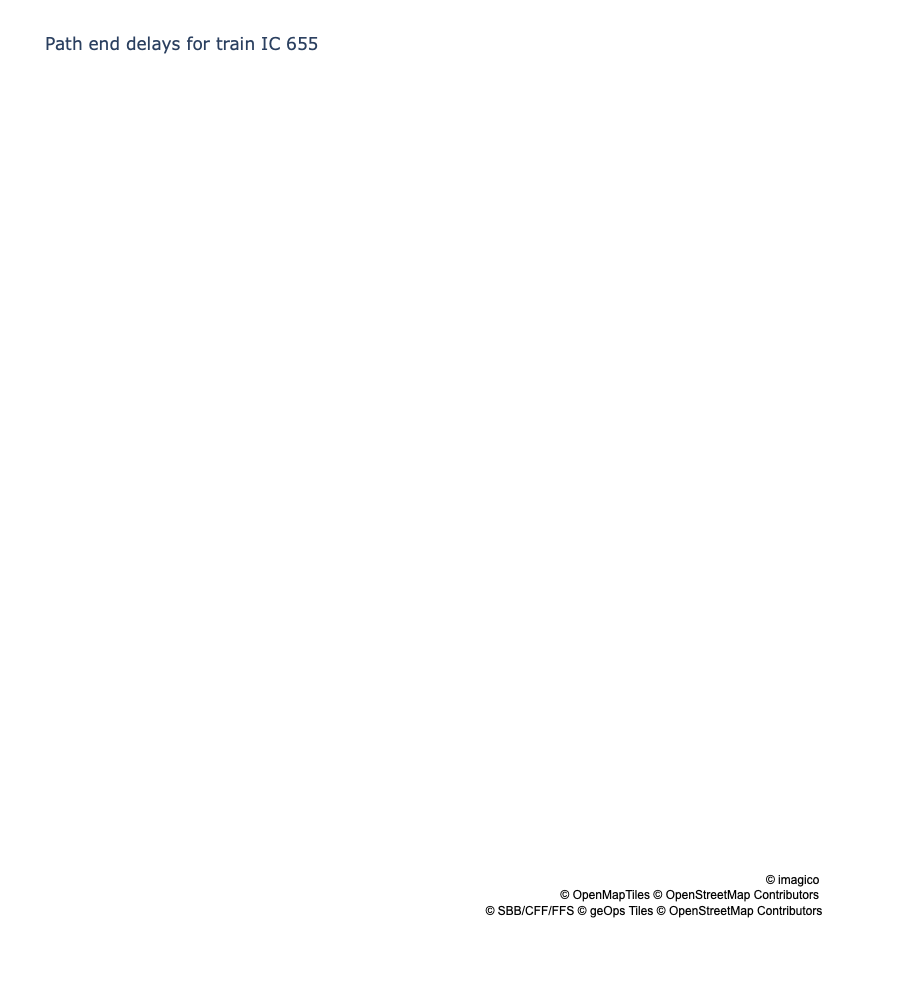

In [182]:
### Show the results
# We now have a shaped GTFS file, we can use it to visualize the train path

# create the map
fig = go.Figure(
    go.Scattermapbox(
        mode = "lines+markers",
        lon = stops_gtfs["stop_lon"],
        lat = stops_gtfs["stop_lat"],
        marker = {'size': 10},
        line = {'width': 5, 'color': 'red'},
    )
)

# add the stops
# fig.add_trace(go.Scattermapbox(
#     lat=stops_gtfs["stop_lat"],
#     lon=stops_gtfs["stop_lon"],
#     mode='markers',
#     marker=go.scattermapbox.Marker(
#         size=9
#     ),
#     text=stops_gtfs["stop_id"],
# ))

fig.update_layout(
    title_text = 'Path end delays for train {} {}'.format(query_7["train_class"], query_7["train_number"]),
    showlegend = False,
    height=700,
    mapbox = {
        
        'center': {'lon': 12.5, 'lat': 42.5},
        # a mapbox style can be found here: https://docs.mapbox.com/api/maps/#styles
        'accesstoken': TOKEN,
        # use sbb style

        'style': "https://maps.geops.io/styles/base_bright_v2/style.json?key=5cc87b12d7c5370001c1d6552688c8395e0e4e94a4faf2368b9915dd",
        
        'zoom': 5,
    },

)
# set size of the map
fig.update_layout(height=1000)

fig.show()



In [156]:
# read GTFS shapes and add them to the map
shapes = pd.read_csv("gtfs/gtfs-out/shapes.txt")

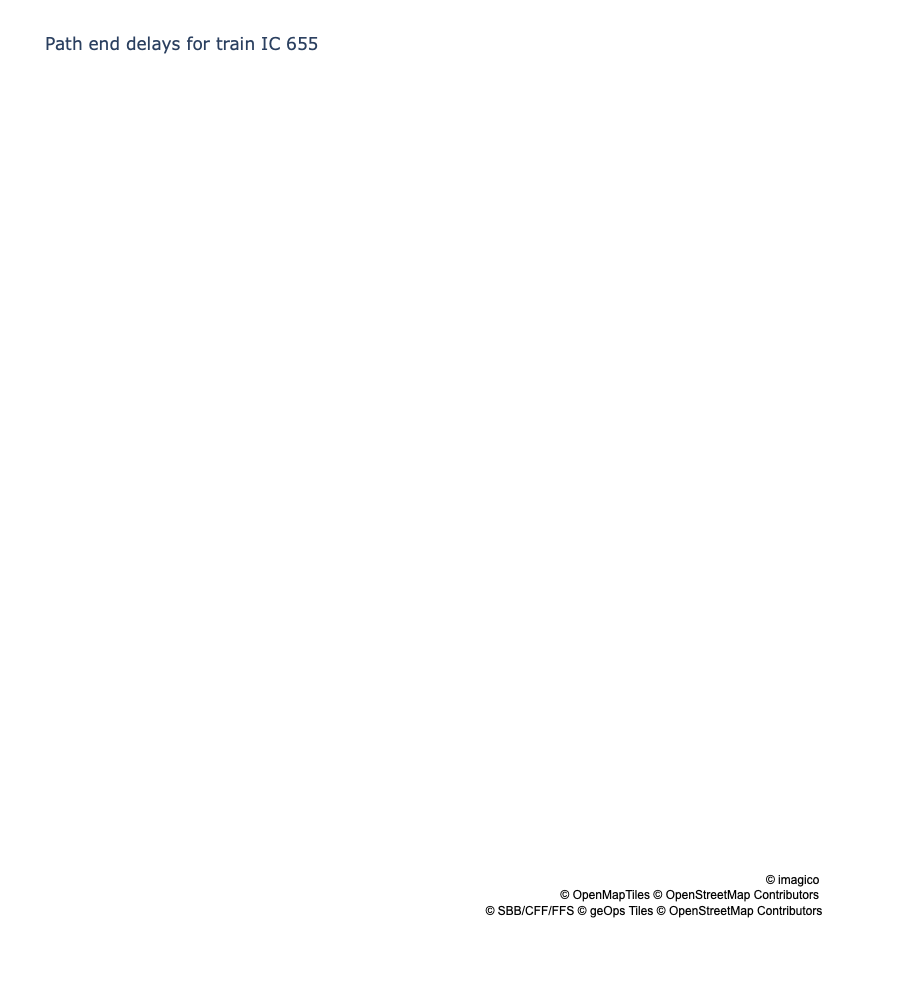

In [198]:
shapes

# add the shapes
fig = go.Figure(go.Scattermapbox(
    lat=shapes["shape_pt_lat"],
    lon=shapes["shape_pt_lon"],
    mode='lines',
    line=go.scattermapbox.Line(
        width=3,
        color='red'
    ),
))

fig.add_trace(
    go.Scattermapbox(
        mode = "lines+markers",
        lon = stops_gtfs["stop_lon"],
        lat = stops_gtfs["stop_lat"],
        text = stops_gtfs["stop_name"],
        marker = {'size': 10},
        line = {'width': 0, 'color': 'red'},
    )
)

fig.update_layout(
    title_text = 'Path end delays for train {} {}'.format(query_7["train_class"], query_7["train_number"]),
    showlegend = False,
    height=700,
    mapbox = {
        
        'center': {'lon': 12.5, 'lat': 42.5},
        # a mapbox style can be found here: https://docs.mapbox.com/api/maps/#styles
        'accesstoken': TOKEN,
        # use sbb style

        'style': "https://maps.geops.io/styles/base_bright_v2/style.json?key=5cc87b12d7c5370001c1d6552688c8395e0e4e94a4faf2368b9915dd",
        
        'zoom': 5,
    },

)
# set size of the map
fig.update_layout(height=1000)

fig.show()
